In [20]:
from dolfin import *
import mshr
import matplotlib.pyplot as plt


def build_space(N_circle, N_bulk, u_in):
    """Prepare data for DGF benchmark. Return function
    space, list of boundary conditions and surface measure
    on the cylinder."""

    # Define domain
    center = Point(0.2, 0.15)
    center2 = Point(0.6, 0.25)
    radius = 0.05
    L = 2.2
    W = 0.41
    geometry = mshr.Rectangle(Point(0.0, 0.0), Point(L, W)) \
             - mshr.Circle(center, radius, N_circle) \
             - mshr.Circle(center2, radius, N_circle) 

    # Build mesh
    mesh = mshr.generate_mesh(geometry, N_bulk)

    # Construct facet markers
    bndry = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
    for f in facets(mesh):
        mp = f.midpoint()
        if near(mp[0], 0.0):  # inflow
            bndry[f] = 1
        elif near(mp[0], L):  # outflow
            bndry[f] = 2
        elif near(mp[1], 0.0) or near(mp[1], W):  # walls
            bndry[f] = 3
        elif mp.distance(center) <= radius:  # cylinder
            bndry[f] = 5
        elif mp.distance(center2) <= radius:  # cylinder
            bndry[f] = 6

    # Build function spaces (Taylor-Hood)
    P2 = VectorElement("P", mesh.ufl_cell(), 2)
    P1 = FiniteElement("P", mesh.ufl_cell(), 1)
    TH = MixedElement([P2, P1])
    W = FunctionSpace(mesh, TH)

    # Prepare Dirichlet boundary conditions
    bc_walls = DirichletBC(W.sub(0), (0, 0), bndry, 3)
    bc_cylinder = DirichletBC(W.sub(0), (0, 0), bndry, 5)
    bc_cylinder2 = DirichletBC(W.sub(0), (0, 0), bndry, 6)
    bc_in = DirichletBC(W.sub(0), u_in, bndry, 1)
    bcs = [bc_cylinder, bc_cylinder2, bc_walls, bc_in]

    # Prepare surface measure on cylinder
    ds_circle = Measure("ds", subdomain_data=bndry, subdomain_id=5)
    ds_circle2 = Measure("ds", subdomain_data=bndry, subdomain_id=6)

    return W, bcs, ds_circle, ds_circle2


def solve_stokes(W, nu, bcs):
    """Solve steady Stokes and return the solution"""

    # Define variational forms
    u, p = TrialFunctions(W)
    v, q = TestFunctions(W)
    a = nu*inner(grad(u), grad(v))*dx - p*div(v)*dx - q*div(u)*dx
    L = inner(Constant((0, 0)), v)*dx

    # Solve the problem
    w = Function(W)
    solve(a == L, w, bcs)

    return w


def solve_navier_stokes(W, nu, bcs):
    """Solve steady Navier-Stokes and return the solution"""

    # Define variational forms
    v, q = TestFunctions(W)
    w = Function(W)
    u, p = split(w)
    F = nu*inner(grad(u), grad(v))*dx + dot(dot(grad(u), u), v)*dx \
        - p*div(v)*dx - q*div(u)*dx

    # Solve the problem
    solve(F == 0, w, bcs)

    return w


def solve_unsteady_navier_stokes(W, nu, bcs, T, dt, theta):
    """Solver unsteady Navier-Stokes and write results
    to file"""

    # Current and old solution
    w = Function(W)
    u, p = split(w)

    w_old = Function(W)
    u_old, p_old = split(w_old)

    # Define variational forms
    v, q = TestFunctions(W)
    F = ( Constant(1/dt)*dot(u - u_old, v)
          + Constant(theta)*nu*inner(grad(u), grad(v))
          + Constant(theta)*dot(dot(grad(u), u), v)
          + Constant(1-theta)*nu*inner(grad(u), grad(v))
          + Constant(1-theta)*dot(dot(grad(u_old), u_old), v)
          - p*div(v)
          - q*div(u)
        )*dx
    J = derivative(F, w)

    # Create solver
    problem = NonlinearVariationalProblem(F, w, bcs, J)
    solver = NonlinearVariationalSolver(problem)
    solver.parameters['newton_solver']['linear_solver'] = 'mumps'

    f = XDMFFile('velocity_unteady_navier_stokes.xdmf')
    u, p = w.split()

    # Perform time-stepping
    t = 0
    while t < T:
        w_old.vector()[:] = w.vector()
        solver.solve()
        t += dt
        f.write(u, t)


def save_and_plot(w, name):
    """Saves and plots provided solution using the given
    name"""

    u, p = w.split()

    # Store to file
    with XDMFFile("results_{}/u.xdmf".format(name)) as f:
        f.write(u)
    with XDMFFile("results_{}/p.xdmf".format(name)) as f:
        f.write(p)

    # Plot
    plt.figure(figsize=(12, 4))
    pl = plot(u, title='velocity {}'.format(name))
    plt.colorbar(pl)
    plt.figure()
    pl = plot(p, title='pressure {}'.format(name))
    plt.colorbar(pl)


def postprocess(w, nu, ds_circle):
    """Return lift, drag and the pressure difference"""

    u, p = w.split()

    # Report drag and lift
    n = FacetNormal(w.function_space().mesh())
    force = -p*n + nu*dot(grad(u), n)
    F_D = assemble(-force[0]*ds_circle)
    F_L = assemble(-force[1]*ds_circle)

    U_mean = 0.2
    L = 0.1
    C_D = 2/(U_mean**2*L)*F_D
    C_L = 2/(U_mean**2*L)*F_L

    # Report pressure difference
    a_1 = Point(0.15, 0.2)
    a_2 = Point(0.25, 0.2)
    try:
        p_diff = p(a_1) - p(a_2)
    except RuntimeError:
        p_diff = 0

    return C_D, C_L, p_diff


def tasks_1_2_3_4():
    """Solve and plot alongside Stokes and Navier-Stokes"""

    # Problem data
    u_in = Expression(("4.0*U*x[1]*(0.41 - x[1])/(0.41*0.41)", "0.0"),
                      degree=2, U=0.3)
    nu = Constant(0.001)

    # Discretization parameters
    N_circle = 16
    N_bulk = 64

    # Prepare function space, BCs and measure on circle
    W, bcs, ds_circle, ds_circle2 = build_space(N_circle, N_bulk, u_in)

    # Solve Stokes
    w = solve_stokes(W, nu, bcs)
    save_and_plot(w, 'stokes')

    # Solve Navier-Stokes
    w = solve_navier_stokes(W, nu, bcs)
    save_and_plot(w, 'navier-stokes')

    # Open and hold plot windows
    plt.show()


def tasks_5_6():
    """Run convergence analysis of drag and lift"""

    # Problem data
    u_in = Expression(("4.0*U*x[1]*(0.41 - x[1])/(0.41*0.41)", "0.0"),
                      degree=2, U=0.3)
    nu = Constant(0.001)

    # Push log levelo to silence DOLFIN
    old_level = get_log_level()
    warning = LogLevel.WARNING if cpp.__version__ > '2017.2.0' else WARNING
    set_log_level(warning)

    fmt_header = "{:10s} | {:10s} | {:10s} | {:10s} | {:10s} | {:10s}"
    fmt_row = "{:10d} | {:10d} | {:10d} | {:10.4f} | {:10.4f} | {:10.6f}"

    # Print table header
    print(fmt_header.format("N_bulk", "N_circle", "#dofs", "C_D", "C_L", "p_diff"))

    # Solve on series of meshes
    for N_bulk in [32, 64, 128]:
        for N_circle in [N_bulk, 2*N_bulk, 4*N_bulk]:

            # Prepare function space, BCs and measure on circle
            W, bcs, ds_circle = build_space(N_circle, N_bulk, u_in)

            # Solve Navier-Stokes
            w = solve_navier_stokes(W, nu, bcs)

            # Compute drag, lift
            C_D, C_L, p_diff = postprocess(w, nu, ds_circle)
            print(fmt_row.format(N_bulk, N_circle, W.dim(), C_D, C_L, p_diff))

    # Pop log level
    set_log_level(old_level)


def task_7():
    """Solve unsteady Navier-Stokes to resolve
    Karman vortex street and save to file"""

    # Problem data
    u_in = Expression(("4.0*U*x[1]*(0.41 - x[1])/(0.41*0.41)", "0.0"),
                      degree=2, U=1)
    nu = Constant(0.001)
    T = 8

    # Discretization parameters
    N_circle = 32
    N_bulk = 128
    theta = 1/2
    dt = 0.1

    # Prepare function space, BCs and measure on circle
    W, bcs, ds_circle, ds_circle2 = build_space(N_circle, N_bulk, u_in)

    # Solve unsteady Navier-Stokes
    solve_unsteady_navier_stokes(W, nu, bcs, T, dt, theta)




Running tasks 1-4


Solving linear variational problem.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.190e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 2.384e-03 (tol = 1.000e-10) r (rel) = 7.474e-04 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 1.050e-03 (tol = 1.000e-10) r (rel) = 3.290e-04 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 1.407e-04 (tol = 1.000e-10) r (rel) = 4.411e-05 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 6.491e-06 (tol = 1.000e-10) r (rel) = 2.035e-06 (tol = 1.000e-09)
  Newton iteration 5: r (abs) = 1.127e-08 (tol = 1.000e-10) r (rel) = 3.532e-09 (tol = 1.000e-09)
  Newton iteration 6: r (abs) = 1.245e-14 (tol = 1.000e-10) r (rel) = 3.903e-15 (tol = 1.000e-09)
  Newton solver finished in 6 iterations and 6 linear solver iterations.


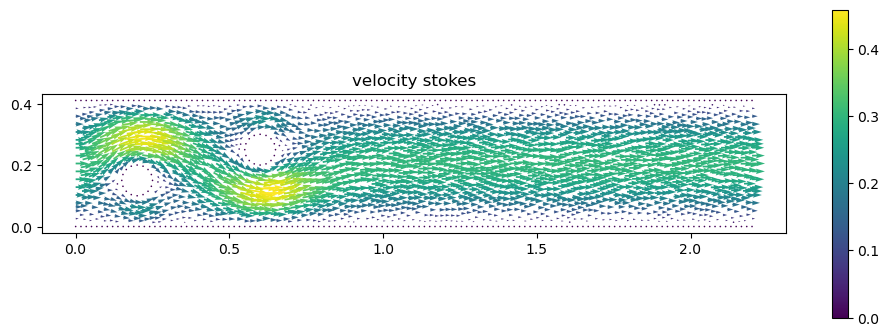

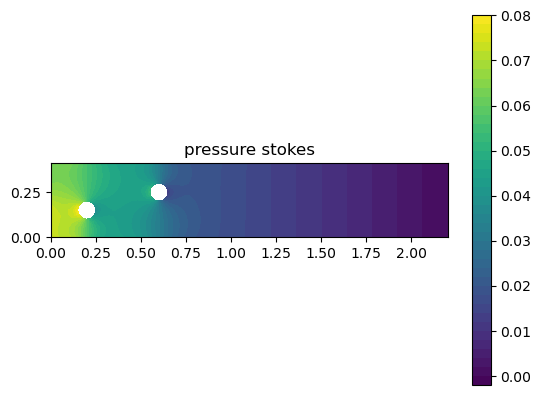

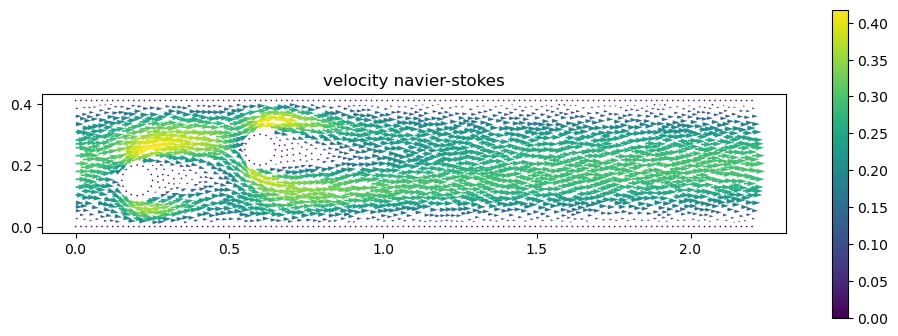

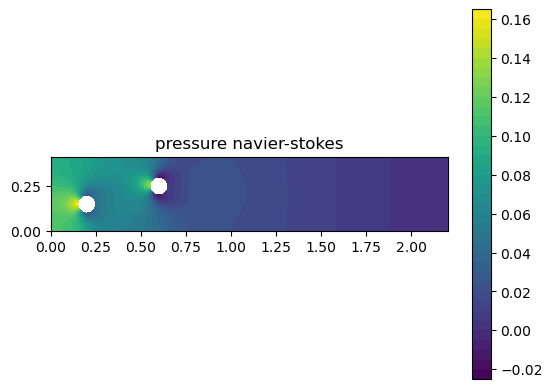



Running tasks 7


Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.473e+01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 5.689e-03 (tol = 1.000e-10) r (rel) = 3.861e-04 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 1.332e-04 (tol = 1.000e-10) r (rel) = 9.040e-06 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 1.094e-07 (tol = 1.000e-10) r (rel) = 7.427e-09 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 1.091e-13 (tol = 1.000e-10) r (rel) = 7.405e-15 (tol = 1.000e-09)
  Newton solver finished in 4 iterations and 4 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.911e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 5.621e-04 (tol = 1.000e-10) r (rel) = 1.437e-02 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 2.753e-06 (tol = 1.000e-10) r (rel) = 7.039e-05 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 1.096e-10 (to

In [21]:
if __name__ == "__main__":
    print("\n")
    print("Running tasks 1-4")
    print("\n")
    tasks_1_2_3_4()
    # print("\n")
    # print("Running tasks 5-6")
    # print("\n")
    # tasks_5_6()
    print("\n")
    print("Running tasks 7")
    print("\n")
    task_7()